In [147]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import duckdb # -> Thư viện "giả lập" xử lý dữ liệu bằng SQL 
from datetime import date
from datetime import time
from sklearn.cluster import KMeans

In [148]:
order_detail_df = pd.read_excel("data/order.xlsx", parse_dates = ['Ngày phát sinh'])
user_df = pd.read_excel("data/user.xlsx")
listening_detail_df = pd.read_excel("data/listening.xlsx")
usage_df = pd.read_excel("data/Usage.xlsx") 

#### Chuyển kiểu dữ liệu

In [149]:
# Chuyển User_ID và Order_ID, Playlist ID sang category
order_detail_df['Order ID'] = order_detail_df['Order ID'].astype('category')
order_detail_df['ID của user'] = order_detail_df['ID của user'].astype('category')

user_df['User ID'] = user_df['User ID'].astype('category')

listening_detail_df['Playlist ID']=listening_detail_df['Playlist ID'].astype('category')
listening_detail_df['User ID']=listening_detail_df['User ID'].astype('category')

usage_df['User ID']=usage_df['User ID'].astype('category')


In [150]:
# Chuyển Ngày phát sinh lượt nghe sang kiểu dữ liệu date
listening_detail_df["Ngày phát sinh lượt nghe"] = listening_detail_df["Ngày phát sinh lượt nghe"].map(
                                        lambda x:date(int(x.split("-")[2]),int(x.split("-")[1]),int(x.split("-")[0])))
listening_detail_df["Ngày phát sinh lượt nghe"] = listening_detail_df["Ngày phát sinh lượt nghe"].astype("datetime64")


In [61]:
order_detail_df.head(3)

,Order ID,Ngày phát sinh,ID của user,Loại hoá đơn (9k/Xu/VIP),Giá trị hoá đơn,order_year,order_month,order_day,order_weekday
0,6706,2020-08-16,44822,VIP,199000,2020,08,16,Sunday
1,6998,2020-08-23,47128,VIP,199000,2020,08,23,Sunday
2,6927,2020-08-21,47134,VIP,199000,2020,08,21,Friday


In [7]:
user_df.head(3)

,User ID,VIP hay Free,Giới tính,Năm sinh,Việt Nam hay Nước ngoài,iOS hay Android,Ngày đăng ký tài khoản,Tổng số lượt nghe,Tổng thời lượng nghe (phút)
0,86229,free,male,NaN,VN,android,2020-11-27,218,4151.3
1,48053,free,male,1995.0,VN,ios,2020-08-24,19,278.6
2,46340,free,male,1988.0,VN,website,2020-08-19,28,170.5


In [8]:
listening_detail_df.head(3)

,Playlist ID,Tên playlist,Category tầng 1 của playlist,Category tầng 2 của playlist,Playlist là Free hay VIP,Thời lượng của playlist (phút),Thời lượng của lượt nghe (phút),User ID,Giờ phát sinh lượt nghe,Ngày phát sinh lượt nghe
0,4529,Dạy Tiếng Anh Cho Trẻ Mầm Non,Podcast,Học ngoại ngữ,free,44.9,0.1,82846,06:05,2020-12-03
1,4577,Tư Duy Tích Cực - Bạn Là Những Gì Bạn Nghĩ (Nh...,Sách nói,Hạnh phúc,vip,79.8,15.9,56112,12:49,2020-10-30
2,4169,50 thiên thần của bạn: Giải phóng bản thân khỏ...,Sách nói,Tâm linh,vip,324.8,6.8,94362,00:17,2020-12-15


In [68]:
# listening_detail_df.to_csv("data/pre_listening.csv")

In [9]:
# listening_detail_df.describe(include = 'all')

In [10]:
# order_detail_df.describe(include = 'all')

In [11]:
# user_df.describe(include = 'all')

#### Khảo sát về sự consistence của các USER_ID trong các file

In [151]:
order_userID = order_detail_df['ID của user'].unique()
userID = user_df['User ID'].unique()
listen_userID = listening_detail_df['User ID'].unique()


user_cnt = len(userID)
order_user_cnt = len(order_userID)
listen_user_cnt = len(listen_userID)

order_nolisten_cnt = len([item for item in order_userID if item  not in listen_userID])
listen_noorder_cnt = len([item for item in listen_userID if item  not in order_userID])
order_listen_cnt = len([item for item in listen_userID if item  in order_userID])


user_stat_dict = {"user_cnt":user_cnt,
                "order_user_cnt": order_user_cnt,
                "listen_user_cnt": listen_user_cnt      
                }

order_listen_stat_dict = {"order_listen_cnt":order_listen_cnt,
                "order_nolisten_cnt": order_nolisten_cnt,
                "listen_noorder_cnt": listen_noorder_cnt      
                }

Text(0.5, 1.0, 'The percentage of users in orders')

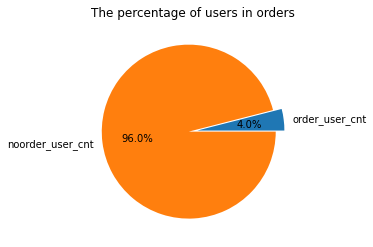

In [152]:
data = [order_user_cnt,user_cnt - order_user_cnt]
label = ["order_user_cnt","noorder_user_cnt"]
plt.pie(x= data , autopct="%.1f%%", explode=[0.05]*len(data),labels=label);
plt.title("The percentage of users in orders")

Text(0.5, 1.0, 'The percentage of users in listening')

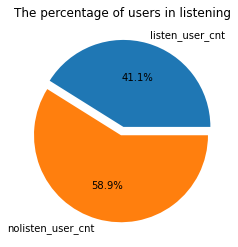

In [153]:
data = [listen_user_cnt,user_cnt - listen_user_cnt]
label = ["listen_user_cnt","nolisten_user_cnt"]
plt.pie(x= data , autopct="%.1f%%", explode=[0.05]*len(data),labels=label);
plt.title("The percentage of users in listening")

Text(0.5, 1.0, 'The percentage of users in orders and listening')

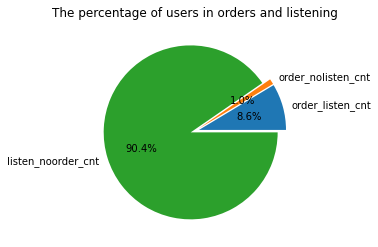

In [154]:
data = order_listen_stat_dict.values()
label = order_listen_stat_dict.keys()
plt.pie(x= data , autopct="%.1f%%", explode=[0.05]*len(data),labels=label);
plt.title("The percentage of users in orders and listening")

##### Xem những người có order mà ko listen hay mua gì

In [155]:
listen_not_in_order_user_df = order_detail_df[~order_detail_df['ID của user'].isin(listening_detail_df['User ID'])]
listen_not_in_order_user_df["Loại hoá đơn (9k/Xu/VIP)"].value_counts()

9K     118
VIP    115
XU      97
Name: Loại hoá đơn (9k/Xu/VIP), dtype: int64

## Xét ORDERs

In [156]:
order_detail_df.head(3)

,Order ID,Ngày phát sinh,ID của user,Loại hoá đơn (9k/Xu/VIP),Giá trị hoá đơn
0,6706,2020-08-16,44822,VIP,199000
1,6998,2020-08-23,47128,VIP,199000
2,6927,2020-08-21,47134,VIP,199000


In [157]:
##### Cắt nhỏ giá trị order_date

order_detail_df['order_year'] = order_detail_df['Ngày phát sinh'].map(lambda x: x.strftime('%Y'))
order_detail_df['order_month'] = order_detail_df['Ngày phát sinh'].map(lambda x: x.strftime('%m'))
order_detail_df['order_day'] = order_detail_df['Ngày phát sinh'].map(lambda x: x.strftime('%d'))
order_detail_df['order_weekday'] = order_detail_df['Ngày phát sinh'].map(lambda x: x.strftime('%A'))
order_detail_df.head(3)

,Order ID,Ngày phát sinh,ID của user,Loại hoá đơn (9k/Xu/VIP),Giá trị hoá đơn,order_year,order_month,order_day,order_weekday
0,6706,2020-08-16,44822,VIP,199000,2020,08,16,Sunday
1,6998,2020-08-23,47128,VIP,199000,2020,08,23,Sunday
2,6927,2020-08-21,47134,VIP,199000,2020,08,21,Friday


## Xét Listenings

In [158]:
listening_detail_df.head(3)

,Playlist ID,Tên playlist,Category tầng 1 của playlist,Category tầng 2 của playlist,Playlist là Free hay VIP,Thời lượng của playlist (phút),Thời lượng của lượt nghe (phút),User ID,Giờ phát sinh lượt nghe,Ngày phát sinh lượt nghe
0,4529,Dạy Tiếng Anh Cho Trẻ Mầm Non,Podcast,Học ngoại ngữ,free,44.9,0.1,82846,06:05,2020-12-03
1,4577,Tư Duy Tích Cực - Bạn Là Những Gì Bạn Nghĩ (Nh...,Sách nói,Hạnh phúc,vip,79.8,15.9,56112,12:49,2020-10-30
2,4169,50 thiên thần của bạn: Giải phóng bản thân khỏ...,Sách nói,Tâm linh,vip,324.8,6.8,94362,00:17,2020-12-15


## Summary Listenings and Orders

In [ ]:
## Tạo order_summary_df và listening_summary_df để chứa dữ liệu thống kê về orders và listenings
## Tạo user_cluster_df để chứa dữ liệu về user_cluster

In [159]:
order_summary_df = order_detail_df.groupby('ID của user').agg(
                    {'Ngày phát sinh': ['min', 'max', 'count'],
                     'Giá trị hoá đơn': 'sum',
                    }
                    ).reset_index()
order_summary_df.columns = ['User_ID','min_purchase_date','max_purchase_date','order_cnt','revenue']

order_summary_df.head(3)

,User_ID,min_purchase_date,max_purchase_date,order_cnt,revenue
0,40843,2020-09-15,2020-10-21,3,27000
1,40861,2020-09-09,2020-09-09,1,199000
2,41003,2020-10-27,2020-10-27,1,599000


In [160]:
listening_summary_df = listening_detail_df.groupby('User ID').agg(
                    {"Ngày phát sinh lượt nghe":['min','max'],
                     "Thời lượng của lượt nghe (phút)":["mean","std",'count','sum']
                    }
                ).reset_index()
listening_summary_df.columns = ['User_ID','first_listen_date','last_listen_date','avg_duration_per_listen','std_avg_duration_per_listen','listen_cnt','total_listen_minute']
listening_summary_df.head(3)

,User_ID,first_listen_date,last_listen_date,avg_duration_per_listen,std_avg_duration_per_listen,listen_cnt,total_listen_minute
0,40834,2020-07-08,2020-07-08,4.350000,6.010408,2,8.7
1,40835,2020-09-02,2020-10-07,13.760000,11.251578,5,68.8
2,40839,2020-07-21,2020-10-11,18.408333,12.992909,60,1104.5


In [56]:
df = [item for item in user_cluster_df["User_ID"].unique() if item  not in usage_df["User ID"].unique() ]
len(df)

7920

In [55]:
usage_df["User ID"] .shape[0]

28344

In [161]:
# Lấy user_id từ 2 bảng order_summary_df và listening_summary_df gộp vào 1 bảng
user_cluster_df= pd.DataFrame(pd.concat(objs=[listening_summary_df['User_ID'],order_summary_df['User_ID']]).drop_duplicates().reset_index(drop=True))
user_cluster_df.columns = ["User_ID"]
user_cluster_df.shape[0]

27458

### Nhận xét về dữ liệu:

In [162]:
da = listening_summary_df.join(order_summary_df[["User_ID","revenue"]].set_index("User_ID"),on="User_ID",how="outer")
da.loc[da["revenue"] <= 0.0].shape[0]

0

In [163]:
t = da.loc[da['revenue'].isnull()]
t[t['total_listen_minute'] == 0.0].shape[0]

93

#### Summary:
1. Ta chỉ xét những user đã có giao dịch hoặc những user đã sử dụng app (đã nghe sách): khoảng 27k users
2. Trong đó, có:
    * Những users đã thực hiện giao dịch đều có tổng giá trị giao dịch > 0.0
    * 1% số lượng PAY users đã giao dịch(order) nhưng chưa nghe (nolisten) (chưa bấm nút nghe của bất kì playlist nào): 275 users
    * 8.6% PAY users đã giao dịch và đã nghe (2363 users)
    * Còn lại 90.4% FREE users đã nghe và CHƯA giao dịch (24820 users), trong đó có 93  free user có tổng thời gian nghe là 0.0 phút -chưa trải nghiệm playlist nào ()

# CLUSTERING

In [ ]:
## Ta đi từ bảng listenning và bảng order
# Có 2 clustering DFM và RFM
# D1: The listening duration / 1 listen(view) # độ lệch của dữ liệu
# D2: The listening duration / a week
# R: The lastest active day

# F: số lượng lượt nghe/1 week
# M : số tiền bỏ ra / 1 week

In [164]:
# for Ebowl
def find_sse(df, max_k):
    sse = {}
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k, max_iter=1000)
        kmeans.fit(df)
        df['clusters'] = kmeans.labels_
        sse[k] = kmeans.inertia_
    return sse
   
## function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

## Calculate metrics

In [ ]:
# D1: avg_duration_per_listen: thời lượng trung bình của 1 lượt nghe
# D2: std_density: độ lệch của thời lương 1 lượt nghe
# D3: avg_listen_duration_per_week: thời lượng nghe tb trong 1 tuần
# R: The lastest listen day: lượt nghe gần nhất
# F: avg_listen_cnt_per_week: số lượt nghe tb trong 1 tuần
# M : avg_spending_per_week: số tiền bỏ ra / 1 week

### Nối các thông tin chung của user lại

In [165]:
# user_cluster_df = user_cluster_df.join(order_summary_df.set_index("User_ID"),on="User_ID",how="outer")
user_cluster_df = user_cluster_df.join(listening_summary_df.set_index("User_ID"),on="User_ID",how="outer")

In [166]:
user_cluster_df = user_cluster_df.join(order_summary_df.set_index("User_ID"),on="User_ID",how="outer")

In [167]:
user_cluster_df = user_cluster_df.join(user_df[["User ID","Ngày đăng ký tài khoản"]].set_index("User ID"),
                                       on="User_ID",how="inner")

In [168]:
user_cluster_df = user_cluster_df.rename(columns = {'Ngày đăng ký tài khoản':'signup_date'})

In [169]:
user_cluster_df["type_user"] = user_cluster_df['revenue'].isnull().map(lambda x: "free" if x else 'subcribe')
user_cluster_df["type_user"].value_counts()

free        24820
subcribe     2638
Name: type_user, dtype: int64

### 1. Density: avg_duration_per_listen: thời lượng trung bình của 1 lượt nghe (theo đơn vị phút)

In [170]:
## Density: thời lượng tb của 1 lượt nghe: Nếu user chưa nghe thì có Density = 0

# 'Density' = 'avg_duration_per_listen' nếu 'avg_duration_per_listen' != NaN, ngược lại thì bằng 0.0
# user_cluster_df['Density'] = user_cluster_df['avg_duration_per_listen'].fillna(value = 0.0)
user_cluster_df['Density'] = user_cluster_df['avg_duration_per_listen']
user_cluster_df['Density'].isnull().sum()

275

In [ ]:
# user_cluster_df["avg_duration_per_listen"].isnull().sum(),user_cluster_df.shape[0]

# # Có 275 user chưa nghe lần nào --> giá trị NaN

In [ ]:
### 2. D2: std_ADPL: độ lệch của thời lương 1 lượt nghe

In [143]:
# user_cluster_df["std_avg_duration_per_listen"].describe()

### 2.Recency: the distance (in days) between the lastest active day of a user and the max  the active day in data set

In [171]:
user_cluster_df['last_active_date'] = user_cluster_df[["max_purchase_date","last_listen_date","signup_date"]].max(axis = 1)

In [172]:
## Recency: khoảng cách giữa lần nghe gần nhất của mỗi user đến max_listen_date trên toàn bộ tập dữ liệu
# the lastest active day = max(the_max_purchase_date, the_last_listen_date,Ngày đăng ký tài khoản)
## Recency càng nhỏ thì càng tốt

maxActiveDay = max(user_cluster_df["max_purchase_date"].max(),user_cluster_df["last_listen_date"].max(),
                      user_cluster_df["signup_date"].max())

user_cluster_df['last_active_date'] = user_cluster_df[["max_purchase_date","last_listen_date","signup_date"]].max(axis = 1)

user_cluster_df['Recency']=(maxActiveDay - user_cluster_df['last_active_date']).dt.days

user_cluster_df['Recency'].isnull().sum()

# users with 0_Recency are the most active ones

0

### 3. Frequency: avg_listen_cnt_per_week: số lượt nghe tb trong 1 tuần

In [173]:
#1 Tính số tuần đã trôi qua trên hệ quy chiếu thời gian của bản thân user
# user_cluster_df['listen_week_cnt'] = round((user_cluster_df['last_listen_date']- user_cluster_df['first_listen_date']).dt.days/7+0.4,0)

user_cluster_df['listen_week_cnt'] = user_cluster_df.apply(
                                lambda x: 1 if x['last_listen_date'] == x["first_listen_date"] 
                                            else round(( x['last_listen_date']-x["first_listen_date"]).days/7 + 0.4,0), axis=1)
#2. Tính số tuần đã trôi qua trên hệ quy chiếu thời gian có cận trên là maxListenDate cho toàn bộ tập dữ liệu
# cận dưới là ngày nghe lần đầu của mỗi user
maxListenDate = user_cluster_df['last_listen_date'].max()
user_cluster_df['bias_listen_week_cnt'] = user_cluster_df["first_listen_date"].map(
                                lambda x: 1 if maxListenDate == x
                                            else round(( maxListenDate-x).days/7 + 0.4,0))

In [174]:
user_cluster_df[['listen_week_cnt']].isnull().sum()

listen_week_cnt    275
dtype: int64

In [175]:
user_cluster_df[user_cluster_df['listen_week_cnt'] == 0].shape[0]

0

In [176]:
#3 Frequency: số lượt nghe tb trong 1 tuần của user:
# Nếu user chưa nghe lần nào (listen_cnt là NaN) thì giá trị này là 0
# còn lại thì bằng tổng số lượt nghe chia tổng số tuần đã trôi qua
# Frequency càng lớn thì càng tốt

user_cluster_df['Frequency'] = user_cluster_df['listen_cnt']/user_cluster_df['listen_week_cnt']
user_cluster_df['Frequency'] = user_cluster_df['Frequency'].fillna(value = float(0.0))

In [177]:
user_cluster_df['Frequency'].isnull().sum()

0

### 5. Monetary

#### 5.1. Monetary_w: avg_spending_per_week: số tiền bỏ ra / 1 life week

In [178]:
# Monetary: avg_spending_per_week: số tiền bỏ ra / 1 week
# Ta lấy revenue của mỗi user chia cho life_week_cnt của user đó
# Nếu revenue của user là NaN: Monetary = 0.0
# Nếu revenue != 0 mà listening

# Timeline của user: từ lúc signup đến lúc the_last_active_date:
user_cluster_df['life_week_cnt']= user_cluster_df.apply(
                                lambda x: 1 if x['last_active_date'] == x["signup_date"] 
                                            else round(( x['last_active_date']-x["signup_date"]).days/7 + 0.4,0), axis=1)

user_cluster_df['Monetary_w'] = user_cluster_df['revenue']
user_cluster_df['Monetary_w'] = user_cluster_df['Monetary_w'] / user_cluster_df['life_week_cnt']

#### 5.2.Monetary_ow: avg_spending_per_week: số tiền bỏ ra / 1 order week

In [272]:
# Monetary: avg_spending_per_week: số tiền bỏ ra / 1 week
# Ta lấy revenue của mỗi user chia cho order_week_cnt của user đó
# Nếu revenue của user là NaN: Monetary = 0.0
# Nếu revenue != 0 mà listening

# Timeline của user: từ lúc the min_purcharse_date đến lúc max_purcharse_date:
user_cluster_df['order_week_cnt']= user_cluster_df.apply(
                                lambda x: 1 if x["max_purchase_date"] == x["min_purchase_date"] 
                                            else round((x["max_purchase_date"]-x["min_purchase_date"]).days/7 + 0.4,0), axis=1)

user_cluster_df['Monetary_ow'] = user_cluster_df['revenue']
user_cluster_df['Monetary_ow'] = user_cluster_df['Monetary_ow'] / user_cluster_df['order_week_cnt']

In [273]:
user_cluster_df.head(3)

,User_ID,first_listen_date,last_listen_date,avg_duration_per_listen,std_avg_duration_per_listen,listen_cnt,total_listen_minute,min_purchase_date,max_purchase_date,order_cnt,...,last_active_date,Recency,listen_week_cnt,bias_listen_week_cnt,Frequency,life_week_cnt,Monetary_w,Monetary_per_listen,order_week_cnt,Monetary_ow
0,40834,2020-07-08,2020-07-08,4.350000,6.010408,2.0,8.7,NaT,NaT,NaN,...,2020-07-08,176,1.0,26.0,2.0,1.0,NaN,NaN,NaN,NaN
1,40835,2020-09-02,2020-10-07,13.760000,11.251578,5.0,68.8,NaT,NaT,NaN,...,2020-10-07,85,5.0,18.0,1.0,14.0,NaN,NaN,NaN,NaN
2,40839,2020-07-21,2020-10-11,18.408333,12.992909,60.0,1104.5,NaT,NaT,NaN,...,2020-10-11,81,12.0,24.0,5.0,15.0,NaN,NaN,NaN,NaN


In [274]:
user_cluster_df['Monetary_ow'].isnull().sum()

24820

#### 5.3. Monetary: avg_spending_per_week: số tiền bỏ ra / 1 listen

In [180]:
# Những người đã order nhưng chưa kịp nghe: cho tổng số lần nghe là 1
user_cluster_df['Monetary_per_listen'] = user_cluster_df['revenue']/user_cluster_df['listen_cnt'].fillna(1)

In [181]:
user_cluster_df['Monetary_per_listen'].isnull().sum()

24820

In [276]:
# user_cluster_df.to_csv("data/user_cluster_df.csv")

In [275]:
user_cluster_df.columns

Index(['User_ID', 'first_listen_date', 'last_listen_date',
       'avg_duration_per_listen', 'std_avg_duration_per_listen', 'listen_cnt',
       'total_listen_minute', 'min_purchase_date', 'max_purchase_date',
       'order_cnt', 'revenue', 'signup_date', 'type_user', 'Density',
       'last_active_date', 'Recency', 'listen_week_cnt',
       'bias_listen_week_cnt', 'Frequency', 'life_week_cnt', 'Monetary_w',
       'Monetary_per_listen', 'order_week_cnt', 'Monetary_ow'],
      dtype='object')

### Summary
1. Có 2 cluster cho 2 nhóm user:
    * Nhóm Free users (type_user = 'free'): RFD
    * Nhóm Subcribe users (type_user = 'subcribe'): RFM
2. Giải thích các metrics:
    * R Recency: khoảng cách tính bằng ngày từ lần active cuối cùng của user đến ngày max(active cuối cùng)
        R càng nhỏ có nghĩa sự recency càng cao --> càng tốt
    * F Frequency: số lượt nghe của mỗi user trong mỗi tuần (listen_cnt/listen_week_cnt)
        F càng cao thì mức độ activeness càng lớn --> càng tốt
        Nếu user chưa nghe lần nào thì Frequency = 0
    * M Monetary: trung bình chi phí cho mỗi lượt nghe (revenue/listen_cnt)
        M càng cao thì càng tốt về mặc lợi nhuận
    * D Density: thời lượng trung bình trong mỗi lượt nghe (total_listen_time / listen_cnt)
        D càng cao --> user càng enjoy app

## NORMALIZE Density - Recency - Frequency - Monetary

In [ ]:
## 1. số thứ tự, 2. quantile, 3. standard scale

In [277]:
user_cluster_df['type_user'].value_counts()

free        24820
subcribe     2638
Name: type_user, dtype: int64

# CLUSTERING

## 1.Subcribers: RFM CLUSTERING (recency - frequency - monetary)

In [278]:
data_cluster_df = user_cluster_df.loc[user_cluster_df['type_user']=='subcribe',["User_ID",'type_user','Recency','Frequency','Monetary_ow']]

In [281]:
data_cluster_df = data_cluster_df.rename(columns={"Monetary_ow": "Monetary"})
data_cluster_df.head(3)

,User_ID,type_user,Recency,Frequency,Monetary
5,40843,subcribe,2,1.846154,4500.0
14,40861,subcribe,29,15.090909,199000.0
61,41003,subcribe,11,14.800000,599000.0


In [283]:
data_cluster_df.shape[0]

2638

In [282]:
data_cluster_df.head(3)

,User_ID,type_user,Recency,Frequency,Monetary
5,40843,subcribe,2,1.846154,4500.0
14,40861,subcribe,29,15.090909,199000.0
61,41003,subcribe,11,14.800000,599000.0


### 1. Normalize: MinMaxScale

In [256]:
# from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [204]:
def min_max_scale(df,scale_cols):
    for col in scale_cols:
        min_val = df[col].min()
        max_val = df[col].max()
        distance = max_val - min_val
        df['scaled'+str(col)] = (df[col]-min_val)/distance
    return df

def run_kmean_clustering(df,cluster_cols,k_cluster,k_iter = 1000):
    kmeans = KMeans(n_clusters=k_cluster, max_iter = k_iter )
    kmeans.fit(df[cluster_cols])
    prefix = cluster_cols[0]
    df[str(prefix)+"Cluster"]= kmeans.predict((df[cluster_cols]))
    return df

In [286]:
data_cluster_df = min_max_scale(data_cluster_df,["Recency","Frequency","Monetary"])
data_cluster_df[["scaledRecency","scaledFrequency","scaledMonetary"]].describe()

,scaledRecency,scaledFrequency,scaledMonetary
count,2638.000000,2638.000000,2638.000000
mean,0.166098,0.078267,0.187870
std,0.210836,0.086760,0.176003
min,0.000000,0.000000,0.000000
25%,0.011905,0.020349,0.022696
50%,0.065476,0.052326,0.164138
75%,0.244048,0.106656,0.253695
max,1.000000,1.000000,1.000000


### Recency

#### 1. Plot R

In [211]:
data_cluster_df['Recency'].describe()

count    2638.000000
mean       27.904473
std        35.420439
min         0.000000
25%         2.000000
50%        11.000000
75%        41.000000
max       168.000000
Name: Recency, dtype: float64

<AxesSubplot:xlabel='Recency', ylabel='Count'>

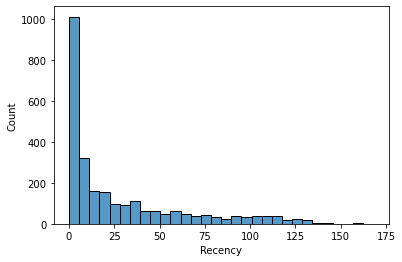

In [214]:
sns.histplot(data=data_cluster_df,x='Recency')

#### 2. Determine K for Recency

In [223]:
data_cluster_df.head(3)

,User_ID,type_user,Recency,Frequency,Monetary,scaledRecency,scaledFrequency,scaledMonetary,RecencyCluster
0,40843,subcribe,2,1.846154,562.500000,0.011905,0.010733,0.000460,2
1,41003,subcribe,11,14.800000,4047.297297,0.065476,0.086047,0.003369,2
2,41014,subcribe,25,4.954545,3651.376147,0.148810,0.028805,0.003039,2


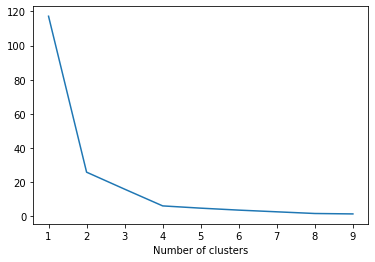

In [224]:
## Elbow Method to determine K

sse = find_sse(data_cluster_df.loc[:,['scaledRecency']], max_k = 10) 

plt.figure()
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel("Number of clusters")
plt.show() 

# # Optimal R_K=3
# ## Choose the k of Recency_clusters = 3
# ## 1st: 'active', 2st: 'sleep', 3rd: 'hibernate'

#### 3. Recency Clustering

In [297]:
# ## RecencyCluster_k = 3
k_clus = 3
data_cluster_df = run_kmean_clustering(data_cluster_df,["scaledRecency"],k_cluster=k_clus)

## Sắp theo thứ tự R càng thấp thì Cluster càng cao
data_cluster_df = order_cluster('scaledRecencyCluster', 'scaledRecency',data_cluster_df,False)
data_cluster_df.groupby("scaledRecencyCluster")['Recency'].describe()

# ## see details of each cluster - Recency

,count,mean,std,min,25%,50%,75%,max
scaledRecencyCluster,,,,,,,,
0,355.0,103.484507,18.468837,75.0,88.5,104.0,116.0,168.0
1,549.0,46.256831,13.535624,27.0,35.0,43.0,57.0,74.0
2,1734.0,6.620531,7.164231,0.0,1.0,4.0,11.0,26.0


#### 4.Summary: Recency chia làm 3 nhóm:
1. Nhóm 0: 'hibernate': khoảng 3 tháng (từ 3-4 tháng) chưa dùng app lại
2. Nhóm 1: 'sleep': khoảng 1.5 tháng trở lại (từ 1 - 2 tháng)chưa dùng app
3. Nhóm 2: 'active': có dùng app trong khoảng 1 tuần (nửa tháng) trở lại đây


### Frequency - số lần nghe trong 1 tuần

#### 1. Plot F

In [231]:
data_cluster_df["Frequency"].describe()

count    2638.00000
mean       13.46189
std        14.92269
min         0.00000
25%         3.50000
50%         9.00000
75%        18.34478
max       172.00000
Name: Frequency, dtype: float64

<AxesSubplot:xlabel='Frequency', ylabel='Count'>

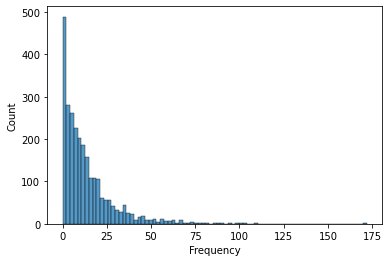

In [232]:
sns.histplot(data=data_cluster_df,x='Frequency')

#### 2. Determine K for Frequency

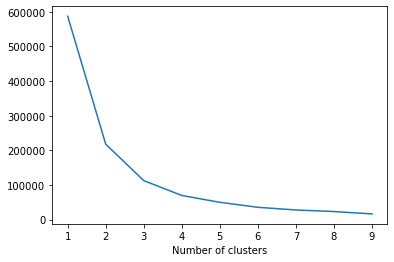

In [244]:
## Elbow Method to determine K

sse = find_sse(data_cluster_df.loc[:,['scaledFrequency']], max_k = 10) 

plt.figure()
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel("Number of clusters")
plt.show() 

# k_optimal  = 4

#### 3. Frequency Clustering

In [296]:
# ## RecencyCluster_k = 4
k_clus = 4
data_cluster_df = run_kmean_clustering(data_cluster_df,["scaledFrequency"],k_cluster=k_clus)

## Sắp theo thứ tự R càng thấp thì Cluster càng cao
data_cluster_df = order_cluster('scaledFrequencyCluster', 'scaledFrequency',data_cluster_df,True)
data_cluster_df.groupby("scaledFrequencyCluster")['Frequency'].describe()

# ## see details of each cluster - Frequency

,count,mean,std,min,25%,50%,75%,max
scaledFrequencyCluster,,,,,,,,
0,1433.0,4.138513,3.170107,0.000000,1.100000,4.000000,6.750000,10.142857
1,812.0,16.234410,4.240668,10.200000,12.592857,15.460526,19.666667,25.611111
2,318.0,35.105726,7.242643,25.750000,29.000000,34.000000,39.459790,52.333333
3,75.0,69.813520,17.889741,54.142857,59.000000,65.333333,74.020833,172.000000


#### 4.Summary: Frequency chia làm 4 nhóm:
1. Nhóm 0: ít dùng : dưới 0-7 lần 1 tuần (mỗi ngày nghe dưới 1 lần)
2. Nhóm 1: Dùng mức độ tb: khoảng 14 - 21 lần 1 tuần (mỗi ngày nghe dưới 3 lần)
3. Nhóm 2: Hay dùng: khoảng 35 lần 1 tuần (mỗi ngày nghe dưới 6 lần)
4. Nhóm 3: Rất hay dùng: khoảng 70 lần mỗi tuần (mỗi ngày nghe khoảng 10 lần trở lên)

### Monetary - số tiền cho 1 tuần order_nghe

#### 1. Plot M

In [288]:
data_cluster_df["Monetary"].describe()

count    2.638000e+03
mean     2.276189e+05
std      2.122489e+05
min      1.058824e+03
25%      2.842857e+04
50%      1.990000e+05
75%      3.070000e+05
max      1.207000e+06
Name: Monetary, dtype: float64

<AxesSubplot:xlabel='Monetary', ylabel='Count'>

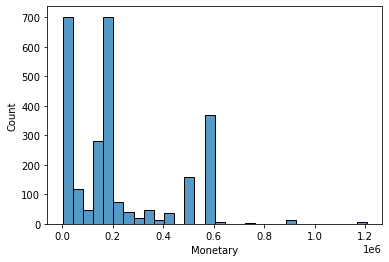

In [289]:
sns.histplot(data=data_cluster_df,x='Monetary')

#### 2. Determine K for Monerary

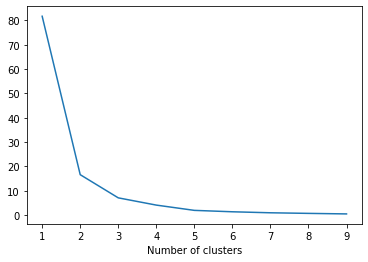

In [290]:
## Elbow Method to determine K

sse = find_sse(data_cluster_df.loc[:,['scaledMonetary']], max_k = 10) 

plt.figure()
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel("Number of clusters")
plt.show() 

# k_optimal  = 3

#### 3. Monerary Clustering

In [291]:
# ## MonetaryCluster_k = 3
k_clus = 3
data_cluster_df = run_kmean_clustering(data_cluster_df,["scaledMonetary"],k_cluster=k_clus)

## Sắp theo thứ tự R càng thấp thì Cluster càng cao
data_cluster_df = order_cluster('scaledMonetaryCluster', 'scaledMonetary',data_cluster_df,True)
data_cluster_df.groupby("scaledMonetaryCluster")['Monetary'].describe()

# ## see details of each cluster - Frequency

,count,mean,std,min,25%,50%,75%,max
scaledMonetaryCluster,,,,,,,,
0,864.0,23580.373181,22792.780201,1058.823529,9000.0,9000.0,28428.571429,1.096667e+05
1,1169.0,198941.379146,43163.077340,113000.000000,168000.0,199000.0,199000.000000,3.740000e+05
2,605.0,574417.630854,103556.161786,390000.000000,499000.0,599000.0,599000.000000,1.207000e+06


#### 4.Summary: Monerary chia làm 3 nhóm:
1. Nhóm 0: Giá trị thấp: trung bình trả 23k cho mỗi tuần theo order (0->50k)chủ yếu mua gói 9k đề dùng thử 
2. Nhóm 1: Giá trị TB: trung bình trả 190k cho mỗi tuần theo order (120k - 390k)
3. Nhóm 2: Giá trị cao: trung bình trả gần 600k cho mỗi tuần theo order (>390k)

In [306]:
data_cluster_df.columns

Index(['User_ID', 'type_user', 'Recency', 'Frequency', 'Monetary',
       'scaledRecency', 'scaledFrequency', 'scaledMonetary',
       'scaledMonetaryCluster', 'scaledFrequencyCluster',
       'scaledRecencyCluster'],
      dtype='object')

In [317]:
user_semgment_data = data_cluster_df[['User_ID', 'type_user', 'Recency', 'Frequency', 'Monetary',
       'scaledMonetaryCluster', 'scaledFrequencyCluster',
       'scaledRecencyCluster']].copy()

In [ ]:
user_semgment_data.rename(columns={'scaledMonetaryCluster':'ValueCluster', 'scaledFrequencyCluster':"FrequencyCluster",
       'scaledRecencyCluster':"RecencyCluster",})

## 2.Free users: RFD CLUSTERING (recency - frequency - Denstity)

### Normalize

In [319]:
free_cluster_df = user_cluster_df.loc[user_cluster_df['type_user']=='free',["User_ID",'type_user','Recency','Frequency','Density']]


In [320]:
free_cluster_df.shape[0]

24820

In [ ]:
free_cluster_df = min_max_scale(data_cluster_df,["Recency","Frequency","Density"])
free_cluster_df[["scaledRecency","scaledFrequency","scaledDensity"]].describe()

### 1. Recency

#### 1. Plot R

In [ ]:
free_cluster_df["Recency"].describe()

In [ ]:
sns.histplot(data=free_cluster_df,x='Recency')

#### 2. Determine K for Monerary

In [ ]:
## Elbow Method to determine K

sse = find_sse(free_cluster_df.loc[:,['scaledFrequency']], max_k = 10) 

plt.figure()
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel("Number of clusters")
plt.show() 

# k_optimal  = 4

#### 3. Recency Clustering

In [ ]:
# ## RecencyCluster_k = 4
k_clus = 4
free_cluster_df = run_kmean_clustering(free_cluster_df,["Recency"],k_cluster=k_clus)

## Sắp theo thứ tự R càng thấp thì Cluster càng cao
free_cluster_df = order_cluster('scaledRecencyCluster', 'scaledRecency',data_cluster_df,True)
free_cluster_df.groupby("scaledRecencyCluster")['Recency'].describe()

# ## see details of each cluster - Frequency

#### 4.Summary: Recency chia làm 3 nhóm:

### 2 Frequency - số lần nghe trong 1 tuần

#### 1. Plot F

In [231]:
free_cluster_df["Frequency"].describe()

count    2638.00000
mean       13.46189
std        14.92269
min         0.00000
25%         3.50000
50%         9.00000
75%        18.34478
max       172.00000
Name: Frequency, dtype: float64

<AxesSubplot:xlabel='Frequency', ylabel='Count'>

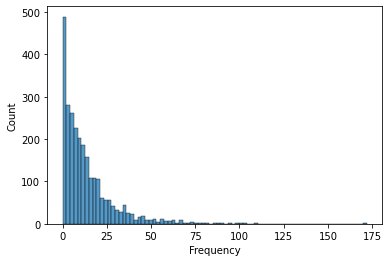

In [232]:
sns.histplot(data=free_cluster_df,x='Frequency')

#### 2. Determine K for Frequency

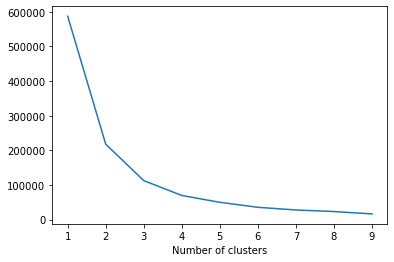

In [244]:
## Elbow Method to determine K

sse = find_sse(free_cluster_df.loc[:,['scaledFrequency']], max_k = 10) 

plt.figure()
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel("Number of clusters")
plt.show() 

# k_optimal  = 4

#### 3. Frequency Clustering

In [296]:
# ## RecencyCluster_k = 4
k_clus = 4
free_cluster_df = run_kmean_clustering(free_cluster_df,["scaledFrequency"],k_cluster=k_clus)

## Sắp theo thứ tự R càng thấp thì Cluster càng cao
free_cluster_df = order_cluster('scaledFrequencyCluster', 'scaledFrequency',free_cluster_df,True)
free_cluster_df.groupby("scaledFrequencyCluster")['Frequency'].describe()

# ## see details of each cluster - Frequency

,count,mean,std,min,25%,50%,75%,max
scaledFrequencyCluster,,,,,,,,
0,1433.0,4.138513,3.170107,0.000000,1.100000,4.000000,6.750000,10.142857
1,812.0,16.234410,4.240668,10.200000,12.592857,15.460526,19.666667,25.611111
2,318.0,35.105726,7.242643,25.750000,29.000000,34.000000,39.459790,52.333333
3,75.0,69.813520,17.889741,54.142857,59.000000,65.333333,74.020833,172.000000


#### 4.Summary: Frequency chia làm 4 nhóm:
1. Nhóm 0: ít dùng : dưới 0-7 lần 1 tuần (mỗi ngày nghe dưới 1 lần)
2. Nhóm 1: Dùng mức độ tb: khoảng 14 - 21 lần 1 tuần (mỗi ngày nghe dưới 3 lần)
3. Nhóm 2: Hay dùng: khoảng 35 lần 1 tuần (mỗi ngày nghe dưới 6 lần)
4. Nhóm 3: Rất hay dùng: khoảng 70 lần mỗi tuần (mỗi ngày nghe khoảng 10 lần trở lên)

### 3.Density - Thời lượng cho mỗi lượt nghe (tính bằng phút)

#### 1. Plot D

In [288]:
free_cluster_df["Density"].describe()

count    2.638000e+03
mean     2.276189e+05
std      2.122489e+05
min      1.058824e+03
25%      2.842857e+04
50%      1.990000e+05
75%      3.070000e+05
max      1.207000e+06
Name: Monetary, dtype: float64

<AxesSubplot:xlabel='Monetary', ylabel='Count'>

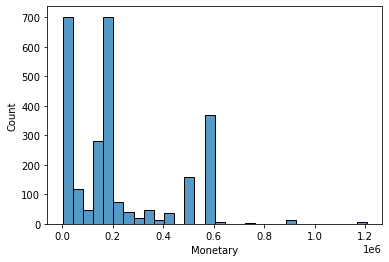

In [289]:
sns.histplot(data=free_cluster_df,x='Density')

#### 2. Determine K for Monerary

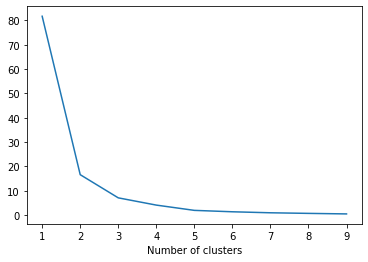

In [290]:
## Elbow Method to determine K

sse = find_sse(free_cluster_df.loc[:,['scaledDensity']], max_k = 10) 

plt.figure()
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel("Number of clusters")
plt.show() 

# k_optimal  = 3

#### 3. Monerary Clustering

In [291]:
# ## DensityCluster_k = 3
k_clus = 3
free_cluster_df = run_kmean_clustering(free_cluster_df,["scaledDensity"],k_cluster=k_clus)

## Sắp theo thứ tự R càng thấp thì Cluster càng cao
free_cluster_df = order_cluster('scaledDensityCluster', 'scaledDensity',free_cluster_df,True)
free_cluster_df.groupby("scaledDensityCluster")['Density'].describe()

# ## see details of each cluster - Frequency

,count,mean,std,min,25%,50%,75%,max
scaledMonetaryCluster,,,,,,,,
0,864.0,23580.373181,22792.780201,1058.823529,9000.0,9000.0,28428.571429,1.096667e+05
1,1169.0,198941.379146,43163.077340,113000.000000,168000.0,199000.0,199000.000000,3.740000e+05
2,605.0,574417.630854,103556.161786,390000.000000,499000.0,599000.0,599000.000000,1.207000e+06


#### 4.Summary: Density chia làm 3 nhóm:
1. Nhóm 0: Giá trị thấp: trung bình trả 23k cho mỗi tuần theo order (0->50k)chủ yếu mua gói 9k đề dùng thử 
2. Nhóm 1: Giá trị TB: trung bình trả 190k cho mỗi tuần theo order (120k - 390k)
3. Nhóm 2: Giá trị cao: trung bình trả gần 600k cho mỗi tuần theo order (>390k)